In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Ignoring warnings (many warnings come from the FairLearn package)
import warnings
warnings.filterwarnings('ignore')

#### Reading in the data and getting an overview

In [3]:
# Starting with 35k observations that have NA values filled from KNN imputation
df = pd.read_csv('na_filled_df.csv').sample(n=35000, random_state=2025)
df.shape

(35000, 21)

****

### Formatting the data

In [4]:
# Selecting the x variables
columns_to_select = ['action_taken', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 'property_value',
                     'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
                     'loan_term', 'negative_amortization', 'occupancy_type', 'income', 'debt_to_income_ratio']
df0 = df[columns_to_select]
df0.shape

(35000, 18)

In [5]:
# Finding categorical variables
string_columns = df0.select_dtypes(include=['object']).columns
string_df = df0[string_columns]
print(string_columns)

Index(['conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category'],
      dtype='object')


In [6]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 3}

In [7]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df0, columns=string_columns, drop_first=True)
df_dummies.shape

(35000, 24)

****

## Building a random forest model

In [8]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [9]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

In [25]:
# Saving predictions to a csv file, making sure to keep sensitive features

# Create a DataFrame from the predictions, using X_test's index
predictions_df = pd.DataFrame(y_pred, index=X_test.index, columns=['predictions'])

# Merge predictions with actual values
rf_v1_test_predictions = pd.concat([predictions_df, y_test], axis=1)

# Merge the combined_df with sensitive_features_test
rf_v1_test_predictions = rf_v1_test_predictions.merge(sensitive_features_test, left_index=True, right_index=True)

rf_v1_test_predictions.to_csv('rf_v1_test_predictions.csv')

# final_df now contains predictions, actuals, and sensitive features, all aligned with the original index


Accuracy: 0.7830
Precision: 0.7968
Recall: 0.9152
F1 Score: 0.8519
Confusion Matrix:


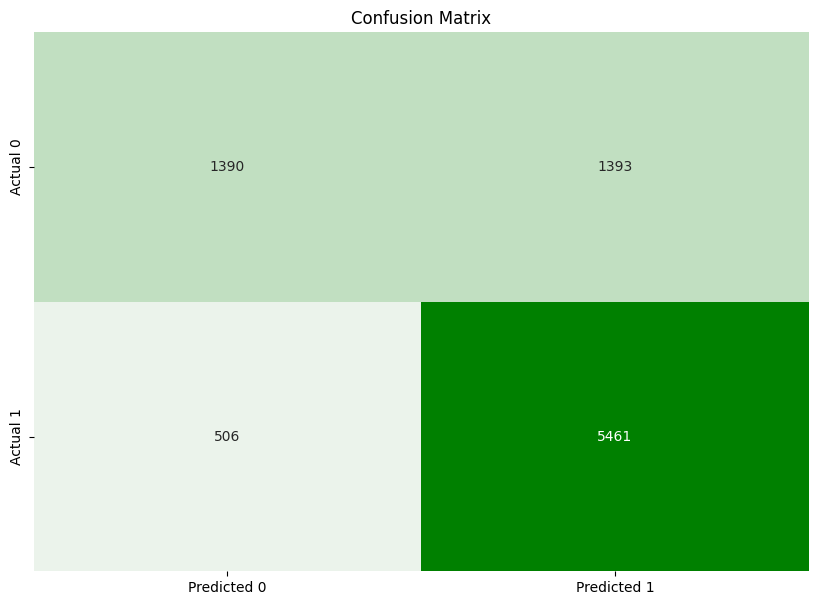

In [10]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

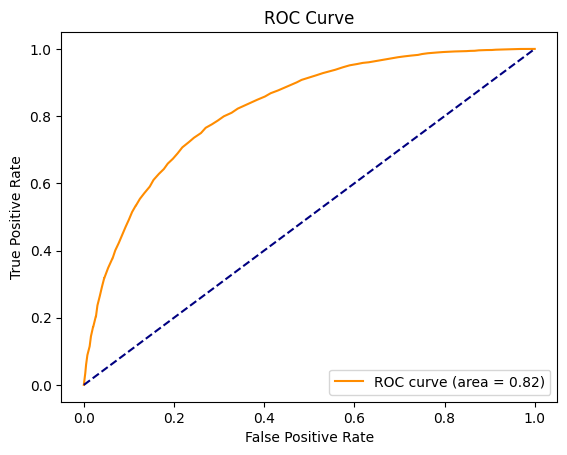

In [11]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

In [12]:
importances = rf0.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

1. loan_to_value_ratio (0.20522659737601576)
2. income (0.17306741487517946)
3. property_value (0.1588216015960447)
4. debt_to_income_ratio (0.13449349884318512)
5. loan_amount (0.1341290664979408)
6. loan_purpose (0.05468009443537493)
7. loan_term (0.04495240674315638)
8. derived_loan_product_type_FHA:First Lien (0.012798579483302064)
9. derived_loan_product_type_VA:First Lien (0.012670069544460138)
10. occupancy_type (0.011881699175291657)
11. open-end_line_of_credit (0.011103555130494392)
12. derived_dwelling_category_Single Family (1-4 Units):Manufactured (0.007284729282062867)
13. preapproval (0.006161087352105725)
14. business_or_commercial_purpose (0.00599988136846998)
15. derived_dwelling_category_Single Family (1-4 Units):Site-Built (0.005693119463653343)
16. lien_status (0.004540726577924644)
17. derived_loan_product_type_Conventional:Subordinate Lien (0.004205338878077482)
18. conforming_loan_limit_NC (0.0032230651989153384)
19. reverse_mortgage (0.003174481345958503)
20. ne

In [ ]:
""" # # Getting shapley values
# # Initializing SHAP explainer
explainer = shap.TreeExplainer(rf0)

# Compute Shapley values for the test set
shap_values = explainer.shap_values(X_test)

# Visualization of SHAP values
shap.summary_plot(shap_values, X_test) """

****

## Looking into metrics with Microsoft Fairlearn

In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [ ]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

In [ ]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

In [ ]:
# Manually defining positives and negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

### Applicant sex

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "F1 score": f1_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

### Applicant race

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

### Applicant age above 62

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, 
    y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

In [ ]:
""" # Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.
print(df['derived_race'].value_counts()/len(df)*100)
sns.countplot(x='derived_race', data=df) """

### Updating the objective function with Exponentiated Gradient mitigation  using Demographic Parity as the objective

In [ ]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

In [ ]:
np.random.seed(2023)

constraint = EqualizedOdds()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['applicant_sex'])

y_pred_mitigated = mitigator.predict(X_test)

### Comparing mitigated to original

In [ ]:
# Define the metrics
metrics_list = ['false_positive_rate', 'false_negative_rate', 'f1_score']

# Initialize an empty dictionary to hold the metrics
metrics_dict = {
    'FPR Male': [],
    'FPR Female': [],
    'FPR Other/NA': [],
    'FNR Male': [],
    'FNR Female': [],
    'FNR Other/NA': [],
    'F1 Male': [],
    'F1 Female': [],
    'F1 Other/NA': []
}

# Populate the dictionary with the metric values for mitigated and original models
for metric_name in metrics_list:
    for group in ['Male', 'Female', 'Other/NA']:
        mitigated_metric = metric_frame_mitigated.by_group[metric_name][group].round(3) if metric_name in metric_frame_mitigated.by_group else None
        original_metric = metric_frame_original.by_group[metric_name][group].round(3) if metric_name in metric_frame_original.by_group else None
        key_suffix = 'FPR' if metric_name == 'false_positive_rate' else 'FNR' if metric_name == 'false_negative_rate' else 'F1'
        metrics_dict[f'{key_suffix} {group}'].append(mitigated_metric)
        metrics_dict[f'{key_suffix} {group}'].append(original_metric)

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print(metrics_df)

In [ ]:
# Define the metrics
metrics = {
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'f1_score': f1_score,
}

# Calculate metrics for the mitigated model
metric_frame_mitigated = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sensitive_features_test['applicant_sex'])

# Calculate metrics for the original model
metric_frame_original = MetricFrame(metrics=metrics,
                                    y_true=y_test,
                                    y_pred=y_pred,
                                    sensitive_features=sensitive_features_test['applicant_sex'])

# Create a dictionary to hold the overall metrics for mitigated and original models
overall_metrics_dict = {
    'FPR': [
        metric_frame_mitigated.overall['false_positive_rate'].round(3),
        metric_frame_original.overall['false_positive_rate'].round(3)
    ],
    'FNR': [
        metric_frame_mitigated.overall['false_negative_rate'].round(3),
        metric_frame_original.overall['false_negative_rate'].round(3)
    ],
    'F1 Score': [
        metric_frame_mitigated.overall['f1_score'].round(3),
        metric_frame_original.overall['f1_score'].round(3)
    ]
}

# Create the DataFrame with 'Mitigated' and 'Original' as the index
overall_metrics_df = pd.DataFrame(overall_metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print('Overall metrics')
print(overall_metrics_df)


### Looking at post processing

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer

# Setup the postprocessed model
postprocessed_model = ThresholdOptimizer(
    estimator= rf0,
    constraints='false_negative_rate_parity',
    objective='balanced_accuracy_score',
    prefit=True  # Since the estimator is already fitted
)

# Fit the ThresholdOptimizer
# Remember to use the test set to avoid data leakage
postprocessed_model.fit(X_test, y_test, sensitive_features=sensitive_features_test['applicant_sex'])

# Generate mitigated predictions
y_pred_postprocessed = postprocessed_model.predict(X_test, sensitive_features=sensitive_features_test['applicant_sex'])


In [ ]:
# Define the metrics
metrics = {
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'f1_score': f1_score
}

# Calculate metrics for the original model
metric_frame_original = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,  # Predictions from the original model
    sensitive_features=sensitive_features_test['applicant_sex']
)

# Calculate metrics for the post-processed model
metric_frame_mitigated = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_postprocessed,  # Predictions from the post-processed model
    sensitive_features=sensitive_features_test['applicant_sex']
)

# Initialize an empty dictionary to hold the metrics
metrics_dict = {
    'FPR Male': [],
    'FPR Female': [],
    'FPR Other/NA': [],
    'FNR Male': [],
    'FNR Female': [],
    'FNR Other/NA': [],
    'F1 Male': [],
    'F1 Female': [],
    'F1 Other/NA': []
}

# Populate the dictionary with the metric values for mitigated and original models
groups = ['Male', 'Female', 'Other/NA']  # Adjust these as per your sensitive attribute categories
for metric_name in metrics:
    for group in groups:
        original_metric = metric_frame_original.by_group[metric_name][group].round(3) if group in metric_frame_original.by_group[metric_name] else None
        mitigated_metric = metric_frame_mitigated.by_group[metric_name][group].round(3) if group in metric_frame_mitigated.by_group[metric_name] else None
        
        key_suffix = 'FPR' if metric_name == 'false_positive_rate' else 'FNR' if metric_name == 'false_negative_rate' else 'F1'
        metrics_dict[f'{key_suffix} {group}'].append(original_metric)
        metrics_dict[f'{key_suffix} {group}'].append(mitigated_metric)

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Original', 'Mitigated'])

# Display the DataFrame
print(metrics_df)
